In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import gc
from sklearn.metrics import classification_report, balanced_accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.preprocessing import LabelEncoder
import sklearn
import seaborn as sns
import tensorflow as tf
from keras import regularizers
from prettytable import PrettyTable

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/Final Yr/labelsCorrect-telugu.zip"

Archive:  /content/drive/MyDrive/Final Yr/labelsCorrect-telugu.zip
  inflating: labelsCorrect-telugu.npy  
  inflating: videosCorrect-telugu.npy  


In [ ]:
videos = np.load('/content/videosCorrect-telugu.npy')
labels = np.load('/content/labelsCorrect-telugu.npy')

In [ ]:
# Print the shape of the videos and labels arrays
print("Videos shape:", videos.shape)
print("Labels shape:", labels.shape)

Videos shape: (454, 22, 80, 112, 3)
Labels shape: (454,)


In [ ]:
labels

array(['bidda', 'nidra', 'maatladu', 'daggara', 'pedda', 'daggara',
       'maatladu', 'pedda', 'pedda', 'bidda', 'bidda', 'bidda', 'raa',
       'bidda', 'bidda', 'pustakam', 'daggara', 'emi', 'daggara',
       'duuramu', 'raa', 'emi', 'vellu', 'raa', 'bidda', 'nidra', 'vellu',
       'bidda', 'maatladu', 'daggara', 'raa', 'bidda', 'raa', 'raa',
       'bidda', 'pedda', 'pedda', 'maatladu', 'maatladu', 'pustakam',
       'emi', 'maatladu', 'duuramu', 'maatladu', 'emi', 'bidda', 'chaala',
       'pustakam', 'nidra', 'nidra', 'bidda', 'raa', 'duuramu', 'nidra',
       'bidda', 'pedda', 'nidra', 'pustakam', 'duuramu', 'raa',
       'pustakam', 'daggara', 'emi', 'duuramu', 'pustakam', 'duuramu',
       'pedda', 'nidra', 'emi', 'duuramu', 'duuramu', 'chaala', 'chaala',
       'vellu', 'pedda', 'pedda', 'duuramu', 'bidda', 'nidra', 'vellu',
       'maatladu', 'chaala', 'bidda', 'nidra', 'pustakam', 'chaala',
       'daggara', 'daggara', 'pedda', 'maatladu', 'vellu', 'bidda',
       'vellu',

In [ ]:
words = list(set(list(labels)))
words.sort()
print(words)

['bidda', 'chaala', 'daggara', 'duuramu', 'emi', 'maatladu', 'nidra', 'pedda', 'pustakam', 'raa', 'vellu']


In [ ]:
label_dict = dict()
for i,j in enumerate(words):
    label_dict[i]=j
    print(label_dict[i],i)

bidda 0
chaala 1
daggara 2
duuramu 3
emi 4
maatladu 5
nidra 6
pedda 7
pustakam 8
raa 9
vellu 10


In [ ]:
print(label_dict)

{0: 'bidda', 1: 'chaala', 2: 'daggara', 3: 'duuramu', 4: 'emi', 5: 'maatladu', 6: 'nidra', 7: 'pedda', 8: 'pustakam', 9: 'raa', 10: 'vellu'}


In [ ]:
encoder = LabelEncoder()
encoder.fit(labels)
encoded_labels = encoder.transform(labels)
labels = encoded_labels

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(videos, labels, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (363, 22, 80, 112, 3) (363,)
Test set shape: (91, 22, 80, 112, 3) (91,)


In [ ]:
gc.collect()
!cat /proc/meminfo | grep Mem

MemTotal:       87532096 kB
MemFree:        73782580 kB
MemAvailable:   80981548 kB


In [ ]:
tf.keras.backend.clear_session()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, BatchNormalization, Dropout, LSTM, Reshape,Bidirectional
from tensorflow.keras import regularizers

input_shape = (22, 80, 112, 3)

model = Sequential()

# Convolutional layers with Batch Normalization and Dropout
model.add(Conv3D(16, (3, 3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling3D((2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(32, (3, 3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling3D((2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(64, (3, 3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling3D((2, 2, 2)))
model.add(Dropout(0.25))

# Reshape to fit LSTM input requirements
model.add(Reshape((-1, 64)))

# Recurrent Layer (LSTM)
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(32)))

# Dense layers with Dropout
model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.3))

model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.3))

model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.3))

# Output layer
model.add(Dense(11, activation='softmax'))


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Convert the target labels to one-hot encoding
y_train_onehot = tf.keras.utils.to_categorical(y_train)
y_test_onehot = tf.keras.utils.to_categorical(y_test)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 20, 78, 110, 16)   1312      
                                                                 
 batch_normalization_6 (Bat  (None, 20, 78, 110, 16)   64        
 chNormalization)                                                
                                                                 
 max_pooling3d_6 (MaxPoolin  (None, 10, 39, 55, 16)    0         
 g3D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 10, 39, 55, 16)    0         
                                                                 
 conv3d_7 (Conv3D)           (None, 8, 37, 53, 32)     13856     
                                                                 
 batch_normalization_7 (Bat  (None, 8, 37, 53, 32)    

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

best_weights_path = 'model_weights-telugu.h5'
# Define the ModelCheckpoint callback to save the best weights
checkpoint = ModelCheckpoint(best_weights_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Define the EarlyStopping callback to stop training if val_accuracy doesn't improve for patience number of epochs
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, mode='max', verbose=1)

In [ ]:
# Train the model and record the history of training
history = model.fit(X_train, y_train_onehot, epochs=150  ,validation_data=(X_test, y_test_onehot),callbacks=[checkpoint,early_stopping])

Epoch 1/150
11/12 [==========================>...] - ETA: 0s - loss: 2.9974 - accuracy: 0.1790
Epoch 1: val_accuracy improved from -inf to 0.05495, saving model to model_weights-telugu.h5
12/12 [==============================] - 11s 270ms/step - loss: 2.9887 - accuracy: 0.1846 - val_loss: 3.0441 - val_accuracy: 0.0549
Epoch 2/150
 1/12 [=>............................] - ETA: 0s - loss: 2.7198 - accuracy: 0.2500

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/12 [==========================>...] - ETA: 0s - loss: 2.4871 - accuracy: 0.3409
Epoch 2: val_accuracy improved from 0.05495 to 0.08791, saving model to model_weights-telugu.h5
12/12 [==============================] - 1s 107ms/step - loss: 2.4768 - accuracy: 0.3388 - val_loss: 3.2507 - val_accuracy: 0.0879
Epoch 3/150
11/12 [==========================>...] - ETA: 0s - loss: 1.9116 - accuracy: 0.4602
Epoch 3: val_accuracy did not improve from 0.08791
12/12 [==============================] - 1s 95ms/step - loss: 1.9118 - accuracy: 0.4573 - val_loss: 3.5876 - val_accuracy: 0.0769
Epoch 4/150
11/12 [==========================>...] - ETA: 0s - loss: 1.5561 - accuracy: 0.5909
Epoch 4: val_accuracy improved from 0.08791 to 0.19780, saving model to model_weights-telugu.h5
12/12 [==============================] - 1s 102ms/step - loss: 1.5452 - accuracy: 0.5950 - val_loss: 3.4081 - val_accuracy: 0.1978
Epoch 5/150
11/12 [==========================>...] - ETA: 0s - loss: 1.2775 - accuracy: 0.70

In [ ]:
model.load_weights(best_weights_path)
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

3/3 [==============================] - 1s 42ms/step


In [ ]:
report = classification_report(y_test, y_pred, output_dict=True)

table = PrettyTable()
table.field_names = ["Class", "Precision", "Recall", "F1-Score", "Support"]
for label, metrics in report.items():
    if label.isdigit():
        precision = round(metrics['precision'], 2)
        recall = round(metrics['recall'], 2)
        f1_score = round(metrics['f1-score'], 2)
        support = metrics['support']
        table.add_row([label_dict[int(label)], precision, recall, f1_score, support])

print(table)

+----------+-----------+--------+----------+---------+
|  Class   | Precision | Recall | F1-Score | Support |
+----------+-----------+--------+----------+---------+
|  bidda   |    0.8    |  1.0   |   0.89   |    8    |
|  chaala  |    1.0    |  0.75  |   0.86   |    8    |
| daggara  |    1.0    |  1.0   |   1.0    |    4    |
| duuramu  |    1.0    |  0.89  |   0.94   |    9    |
|   emi    |    1.0    |  1.0   |   1.0    |    8    |
| maatladu |    0.89   |  1.0   |   0.94   |    8    |
|  nidra   |    1.0    |  1.0   |   1.0    |    9    |
|  pedda   |    1.0    |  1.0   |   1.0    |    12   |
| pustakam |    1.0    |  1.0   |   1.0    |    5    |
|   raa    |    1.0    |  1.0   |   1.0    |    10   |
|  vellu   |    1.0    |  1.0   |   1.0    |    10   |
+----------+-----------+--------+----------+---------+


In [ ]:
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_pred)*100)

Balanced accuracy: 96.71717171717172


3/3 [==============================] - 0s 43ms/step


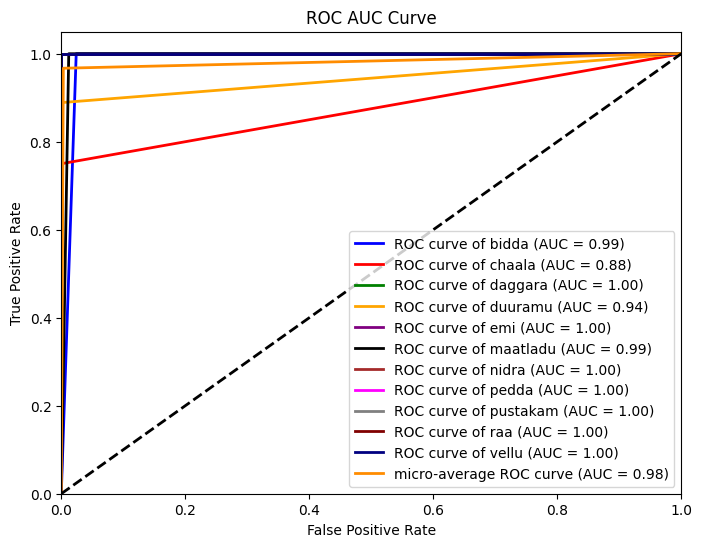

In [ ]:
# Convert y_true and y_pred to one-hot encoding
n_classes = len(np.unique(y_test))
y_true_bin = label_binarize(y_test, classes=np.arange(n_classes))
y_pred_bin = model.predict(X_test)
y_pred_bin = label_binarize(np.argmax(y_pred_bin, axis=1), classes=np.arange(n_classes))

# Compute ROC curve and ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC AUC
fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), y_pred_bin.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot ROC curves
plt.figure(figsize=(8,6))
lw = 2
colors = ['blue', 'red', 'green', 'orange', 'purple', 'black', 'brown', 'magenta', 'gray', 'maroon', 'navy', 'olive', 'pink']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of {0} (AUC = {1:0.2f})'
             ''.format(label_dict[i], roc_auc[i]))
plt.plot(fpr_micro, tpr_micro, color='darkorange', lw=lw,
         label='micro-average ROC curve (AUC = {0:0.2f})'
         ''.format(roc_auc_micro))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend(loc="lower right")
plt.show()

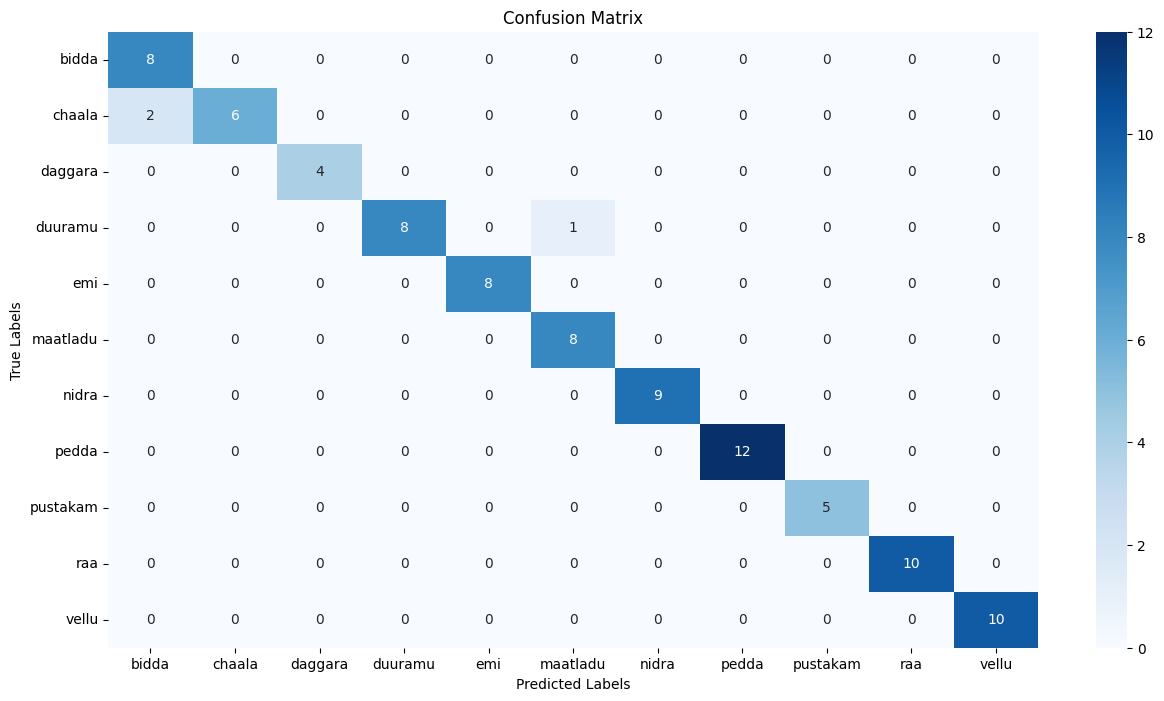

In [ ]:
conf_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred)

# Define the list of label strings in the order of their integer values
label_strings = [label_dict[i] for i in range(len(label_dict))]

# Generate the heatmap confusion matrix
plt.figure(figsize=(15,8))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", xticklabels=label_strings, yticklabels=label_strings)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()